In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [ ]:
# data set download to vm
!wget https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/CECS551_dataset_02.zip

--2022-12-05 07:39:35--  https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/CECS551_dataset_02.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/CECS551_dataset_02.zip [following]
--2022-12-05 07:39:35--  https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/CECS551_dataset_02.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70757765 (67M) [application/zip]
Saving to: ‘CECS551_dataset_02.zip’

CECS551_dataset_02. 100%[===================>]  67.48M   185MB/s    in 0.4s    

2022-12-05 07:39:39 (185 MB/s) -

In [ ]:
# download the weather data
# obtained this data from https://www.noaa.gov/
!wget https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/weather.csv

--2022-12-05 07:39:41--  https://github.com/bhanusumanth/ai-sales-predict-dataset/raw/master/weather.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/weather.csv [following]
--2022-12-05 07:39:41--  https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1488939 (1.4M) [text/plain]
Saving to: ‘weather.csv’

weather.csv         100%[===================>]   1.42M  --.-KB/s    in 0.02s   

2022-12-05 07:39:41 (64.7 MB/s) - ‘weather.csv’ saved [1488939/1488939]



In [ ]:
!wget https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/median_income.csv

--2022-12-05 07:39:44--  https://raw.githubusercontent.com/bhanusumanth/ai-sales-predict-dataset/master/median_income.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283 [text/plain]
Saving to: ‘median_income.csv’

median_income.csv   100%[===================>]     283  --.-KB/s    in 0s      

2022-12-05 07:39:44 (14.4 MB/s) - ‘median_income.csv’ saved [283/283]



In [ ]:
!unzip -q CECS551_dataset_02.zip

In [ ]:
# load to pandas dataframes
sales_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/tableau_sales_train_evaluation_365_days.csv")
sell_prices_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/sell_prices.csv")
weather_raw = pd.read_csv('/content/weather.csv')
calendar_raw = pd.read_csv("/content/CECS551_dataset_02/Tableau/calendar.csv")
median_income_raw = pd.read_csv('/content/median_income.csv')

In [ ]:

sales = sales_raw.copy()
sell_prices = sell_prices_raw.copy()
calendar = calendar_raw.copy()
weather = weather_raw.copy()

In [ ]:
sales['id'] = sales['store_id'] + '-' + sales['item_id']

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,CA_1-HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,CA_1-HOBBIES_1_003,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,8,1,3,0,1,2,3
4,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Converting calendar data to a dictionary

In [ ]:
dict_week = dict(zip(calendar.d.values, calendar.wm_yr_wk.values))

Create a pivot on sell prices for each product based on week year number

In [ ]:
print("{:,} records for sales price".format(len(sell_prices)))
# SKU Index
sell_prices['item_store_id'] = sell_prices['store_id'] + '-' + sell_prices['item_id']
# Pricing
sell_prices = sell_prices.pivot(index='item_store_id', columns='wm_yr_wk', values='sell_price').fillna(0)

6,841,121 records for sales price


Create a dictionary for item_store_id from 0 to 30k and similarly for wm_yr_wk for each record 0 to 281

In [ ]:
# Matrix from pivot
matrix_price = sell_prices.to_numpy()
# Dict Matrix Index
pr_n = dict(zip(sell_prices.index, range(len(sell_prices.index))))
pr_p = dict(zip(sell_prices.columns, range(len(sell_prices.columns))))
print("{:,} records for sales price pivot".format(len(sell_prices)))

30,490 records for sales price pivot


Calculating Mean and standrd deviation

In [ ]:
# Mean
COLS_ITM = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
COLS_DATE = ['d_' + str(i) for i in range(1, 366)]
sales['mean'] = sales[COLS_DATE].mean(axis = 1)
# Standard deviation
sales['std'] = sales[COLS_DATE].std(axis = 1)
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,mean,std
0,CA_1-HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
1,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,0,0.175342,0.459270
2,CA_1-HOBBIES_1_003,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
3,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,8,1,3,0,1,2,3,1.282192,1.504512
4,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0.794521,1.543854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,WI_3-FOODS_3_823,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,1.364384,1.989351
30486,WI_3-FOODS_3_824,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,0,0,0,0,0,0.805479,1.057663
30487,WI_3-FOODS_3_825,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,1,1,0,0,1,0,0,1,1.378082,1.972214
30488,WI_3-FOODS_3_826,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000


There are zero sales for some products example CA_1-HOBBIES_1_001. This  product has 0 mean sales for entire year. dropping such products.

In [ ]:
# Remove items not sold during the first year
print("{:,} records for the full scope".format(len(sales)))
sales = sales[sales['mean']>0]
print("{:,} records for after filter".format(len(sales)))
sales.reset_index(inplace = True)
sales = sales.drop('index', axis=1)
sales.head()

30,490 records for the full scope
17,055 records for after filter


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,mean,std
0,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,0,0.175342,0.459270
1,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,8,1,3,0,1,2,3,1.282192,1.504512
2,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0.794521,1.543854
3,CA_1-HOBBIES_1_008,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,20,26,0,9,14,0,8,18,6.854795,8.556423
4,CA_1-HOBBIES_1_009,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,1,0,0,3,0,1.816438,2.486613


Calculate revenue generated
using revenue = price * units sold

In [ ]:
# Total Units
sales['units'] = sales[COLS_DATE].sum(axis = 1)
# Turnover = Units x Price
sales['TR'] = 0
for col in tqdm(COLS_DATE):
    sales['TR'] = sales['TR'] + sales[col] * sales[['id', col]].apply(
        lambda t: matrix_price[pr_n[t['id']], pr_p[dict_week[col]]], axis = 1)
# Sigma
sales.head()

100%|██████████| 365/365 [01:00<00:00,  6.05it/s]


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_360,d_361,d_362,d_363,d_364,d_365,mean,std,units,TR
0,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,1,0,0,0.175342,0.459270,64,254.08
1,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,2,3,1.282192,1.504512,468,2031.12
2,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0.794521,1.543854,290,800.70
3,CA_1-HOBBIES_1_008,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,9,14,0,8,18,6.854795,8.556423,2502,1237.92
4,CA_1-HOBBIES_1_009,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,1,0,0,3,0,1.816438,2.486613,663,1151.04


Coefficient of variation =   ~ std/mean

In [ ]:
sales['CV'] = sales['std'] / sales['mean']
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_361,d_362,d_363,d_364,d_365,mean,std,units,TR,CV
0,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,0,0,0.175342,0.459270,64,254.08,2.619273
1,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,3,0,1,2,3,1.282192,1.504512,468,2031.12,1.173391
2,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0.794521,1.543854,290,800.70,1.943127
3,CA_1-HOBBIES_1_008,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,9,14,0,8,18,6.854795,8.556423,2502,1237.92,1.248239
4,CA_1-HOBBIES_1_009,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,3,0,1.816438,2.486613,663,1151.04,1.368950


Product Segmentation ABC Analysis + Demand variability
create a copy of df where we focus on Household category.

In [ ]:
# ABC SKU-LEVEL
df_abc = sales[sales['cat_id']=='HOUSEHOLD'].drop(['mean', 'std', 'CV'], axis = 1).copy()
df_abc = df_abc.groupby(['item_id', 'dept_id', 'cat_id']).sum()
df_abc.head()


,,,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,units,TR
item_id,dept_id,cat_id,,,,,,,,,,,,,,,,,,,,,
HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,7,3,2,2,1,4,3,6,1,1,...,5,6,5,1,2,3,4,6,1161,7813.78
HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,8,7,5,10,4,1,6,12,7,3,...,7,2,2,1,0,4,3,5,1221,8104.12
HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,26,25,28,29,9,16,18,27,25,33,...,19,19,23,12,19,26,19,17,3344,7198.32
HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,11,14,7,7,4,15,6,12,11,9,...,16,9,11,6,7,10,12,15,2497,25975.37
HOUSEHOLD_1_006,HOUSEHOLD_1,HOUSEHOLD,0,0,0,0,0,0,0,0,0,0,...,8,11,7,2,8,3,1,5,1264,8810.08


In [ ]:
# Calculate mean and standard deviation for groups
# Mean
df_abc['mean'] = df_abc[COLS_DATE].mean(axis = 1)
# Filter out the reference withou sales
df_abc = df_abc[df_abc['mean']>0]
# Standard
df_abc['std'] = df_abc[COLS_DATE].std(axis = 1)
# Coefficient of Variation
df_abc['CV'] = df_abc['std']/df_abc['mean']
df_abc.reset_index(inplace = True)
# Normalility Test
df_abc['Normality_p'] = df_abc[COLS_DATE].apply(lambda row : stats.shapiro(row)[1], axis = 1)
# level of significance alpha is set to 0.01 for checking highly significance
alpha = 0.001
df_abc['Not_Normal'] = df_abc['Normality_p'] < alpha
df_abc.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_363,d_364,d_365,units,TR,mean,std,CV,Normality_p,Not_Normal
0,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,7,3,2,2,1,4,3,...,3,4,6,1161,7813.78,3.180822,2.063595,0.648761,2.928753e-12,True
1,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,8,7,5,10,4,1,6,...,4,3,5,1221,8104.12,3.345205,2.171559,0.649156,1.568825e-10,True
2,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,26,25,28,29,9,16,18,...,26,19,17,3344,7198.32,9.161644,12.215944,1.333379,1.658789e-22,True
3,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,11,14,7,7,4,15,6,...,10,12,15,2497,25975.37,6.841096,5.464366,0.798756,3.987799e-12,True
4,HOUSEHOLD_1_006,HOUSEHOLD_1,HOUSEHOLD,0,0,0,0,0,0,0,...,3,1,5,1264,8810.08,3.463014,4.543668,1.312056,5.441153e-22,True


In [ ]:
from pandas._libs.algos import diff_2d
# # ABC SKU-LEVEL
df_abc = df_abc.drop(COLS_DATE, axis =1).copy()
# TRP = Total revenue percentage for each item over year
df_abc['TRP'] = (100*df_abc['TR']/df_abc['TR'].sum())
# Sort
df_abc.sort_values(['TRP'], ascending = False, inplace = True, ignore_index=True)
# computing cumulative sum of TRP
df_abc['TRP_CS'] = df_abc['TRP'].cumsum()
df_abc.tail()


,item_id,dept_id,cat_id,units,TR,mean,std,CV,Normality_p,Not_Normal,TRP,TRP_CS
644,HOUSEHOLD_1_394,HOUSEHOLD_1,HOUSEHOLD,2,9.76,0.005479,0.073922,13.490687,5.808091e-39,True,0.000131,99.999848
645,HOUSEHOLD_2_346,HOUSEHOLD_2,HOUSEHOLD,1,3.00,0.002740,0.052342,19.104973,3.135480e-39,True,0.000040,99.999888
646,HOUSEHOLD_2_401,HOUSEHOLD_2,HOUSEHOLD,1,3.00,0.002740,0.052342,19.104973,3.135480e-39,True,0.000040,99.999928
647,HOUSEHOLD_1_529,HOUSEHOLD_1,HOUSEHOLD,1,2.87,0.002740,0.052342,19.104973,3.135480e-39,True,0.000038,99.999967
648,HOUSEHOLD_2_230,HOUSEHOLD_2,HOUSEHOLD,1,2.48,0.002740,0.052342,19.104973,3.135480e-39,True,0.000033,100.000000


In [ ]:
# A, B, C on SKU Number
n_sku = len(df_abc)
n_a, n_b = int(0.05*n_sku), int(0.2*n_sku)
df_abc['SKU_ID'] = pd.Series(range(1, len(df_abc))).astype(int)
df_abc['SKU_P'] = (100 * pd.Series(range(1, len(df_abc))) / len(df_abc))
df_abc['ABC'] = pd.Series(range(len(df_abc))).apply(lambda t: 'A' if t <= n_a-1 else 'B' if t <= n_b-1 else 'C')
# A, B, C on turnover
to_a, to_b = df_abc[df_abc['SKU_ID']==n_a]['TRP'].max(), df_abc[df_abc['SKU_ID']==n_b]['TRP'].max()

print("{:,} unique SKU".format(len(df_abc)))
df_abc.head()


649 unique SKU


,item_id,dept_id,cat_id,units,TR,mean,std,CV,Normality_p,Not_Normal,TRP,TRP_CS,SKU_ID,SKU_P,ABC
0,HOUSEHOLD_1_272,HOUSEHOLD_1,HOUSEHOLD,13140,131153.24,36.000000,12.032694,0.334241,1.809400e-06,True,1.755437,1.755437,1.0,0.154083,A
1,HOUSEHOLD_1_535,HOUSEHOLD_1,HOUSEHOLD,16363,114050.11,44.830137,32.722420,0.729920,2.122261e-12,True,1.526518,3.281956,2.0,0.308166,A
2,HOUSEHOLD_1_072,HOUSEHOLD_1,HOUSEHOLD,11944,96733.54,32.723288,11.058915,0.337952,4.101105e-01,False,1.294742,4.576698,3.0,0.462250,A
3,HOUSEHOLD_1_053,HOUSEHOLD_1,HOUSEHOLD,5936,89924.92,16.263014,8.938242,0.549606,2.806232e-07,True,1.203612,5.780310,4.0,0.616333,A
4,HOUSEHOLD_1_440,HOUSEHOLD_1,HOUSEHOLD,5865,89088.55,16.068493,8.353996,0.519899,5.087669e-06,True,1.192417,6.972727,5.0,0.770416,A


In [ ]:
import plotly.graph_objects as go
import numpy as np

x = df_abc['SKU_P']
y = df_abc['TRP_CS']

fig = go.Figure(data=go.Scatter(x=x, y=y, name="Revenue percent cumulative sum", showlegend=True,))
fig.update_layout(
    autosize=False,
    width=1100,
    height=600,)
fig.add_vline(x=5, line_width=1, line_color="red")
fig.add_vline(x=20, line_width=1, line_color="red")
fig.add_hline(y=80, line_width=1, line_dash="dash",line_color="green")
fig.add_hline(y=95, line_width=1, line_dash="dash",line_color="green")
fig.update_layout(
    title="ABC Analysis: Distribution by Revenue (Sales Value in $)",
    xaxis_title="Percentage of SKU percent",
    yaxis_title="Percentage of the Annual Revenue percent"
)
fig.show()

In [ ]:
class_a = df_abc[df_abc['ABC'] == 'A'].copy()
class_b = df_abc[df_abc['ABC'] == 'B'].copy()
class_c = df_abc[df_abc['ABC'] == 'C'].copy()

In [ ]:
print("Class A : top 5 %")
print("  Number of SKU : ",len(class_a))
print("  Revenue Percent : ",class_a['TRP'].sum())
print("Class B : next 15 %")
print("  Number of SKU : ",len(class_b))
print("  Revenue Percent : ",class_b['TRP'].sum())
print("Class C : next  80 %")
print("  Number of SKU : ",len(class_c))
print("  Revenue Percent : ",class_c['TRP'].sum())

Class A : top 5 %
  Number of SKU :  32
  Revenue Percent :  25.226679543392244
Class B : next 15 %
  Number of SKU :  97
  Revenue Percent :  29.621980305042495
Class C : next  80 %
  Number of SKU :  520
  Revenue Percent :  45.15134015156527


 Evaluating Coefficient of Variation

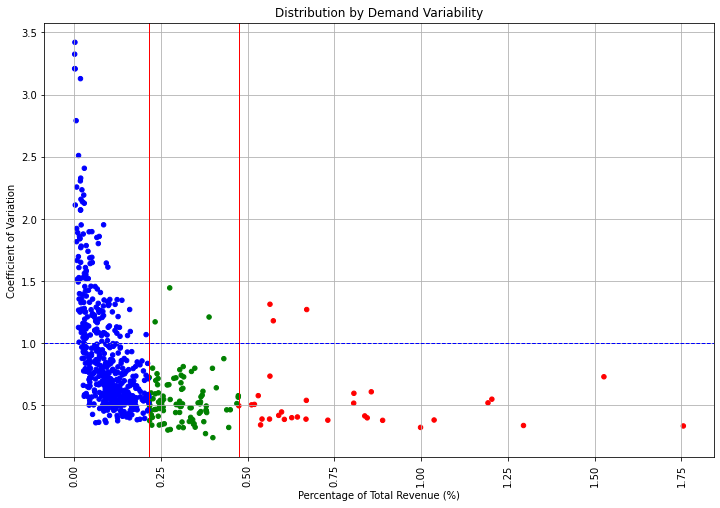

In [ ]:
# Bar Chart
ax = plt.gca()
colors = {'A':'red', 'B':'green', 'C':'blue'}
# Remove Outliers
df_plot = df_abc[df_abc['CV']<4].copy()
df_plot.plot.scatter(figsize=(12, 8), x='TRP', y='CV', color=df_plot['ABC'].map(colors), ax =ax, grid = True)
# ABC
# A, B and C
ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of Total Revenue (%)')
plt.xticks(rotation=90)
plt.ylabel('Coefficient of Variation')
plt.title('Distribution by Demand Variability')
plt.show()



In [ ]:
def xyz_classification(cov):
    if cov <= 0.5:
        return 'X'
    elif cov > 0.5 and cov <= 1.0:
        return 'Y'
    else:
        return 'Z'

In [ ]:
df_abc['xyz_category'] = df_abc['CV'].apply(xyz_classification)
df_abc.xyz_category.value_counts()

Y    342
Z    194
X    113
Name: xyz_category, dtype: int64

**Distribution of an item with Low coefficient of variation**

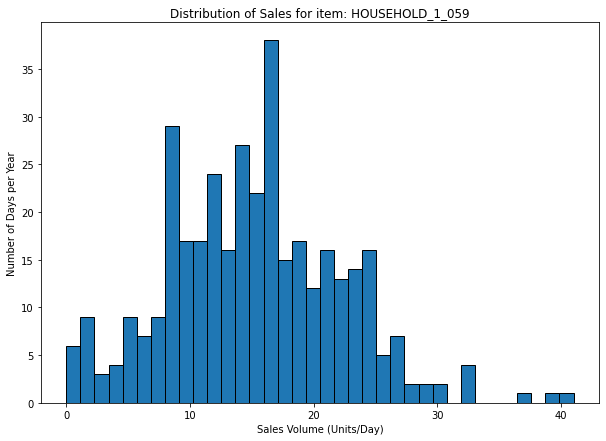

In [ ]:
# ABC SKU-LEVEL
df_dist = sales[sales['cat_id']=='HOUSEHOLD'].drop(['mean', 'std', 'CV'], axis = 1).copy()
df_dist = pd.DataFrame(df_dist.groupby(['item_id', 'dept_id', 'cat_id']).sum())
df_dist.reset_index(inplace = True)

# Item A
item_high = 'HOUSEHOLD_1_059'
df_dist = df_dist[df_dist['item_id']==item_high][COLS_DATE].T
df_dist.columns = ['Units']

# Simple histogram
df_dist['Units'].hist(figsize=(10,7), edgecolor='black', grid = False, bins = df_dist['Units'].nunique()) # , linewidth=1.2 , bins = 30
plt.xlabel('Sales Volume (Units/Day)')
plt.ylabel('Number of Days per Year')
plt.title('Distribution of Sales for item: {}'.format(item_high))
plt.show()


**Distribution of an item with Average coefficient of variation**

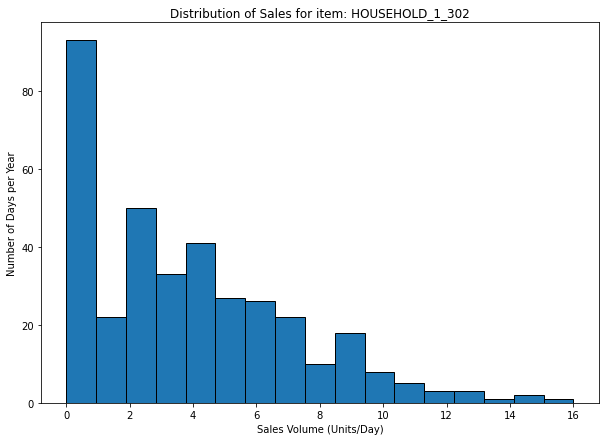

In [ ]:
# ABC SKU-LEVEL
df_dist = sales[sales['cat_id']=='HOUSEHOLD'].drop(['mean', 'std', 'CV'], axis = 1).copy()
df_dist = pd.DataFrame(df_dist.groupby(['item_id', 'dept_id', 'cat_id']).sum())
df_dist.reset_index(inplace = True)

# Item A
item_high = 'HOUSEHOLD_1_302'
df_dist = df_dist[df_dist['item_id']==item_high][COLS_DATE].T
df_dist.columns = ['Units']

# Simple histogram
df_dist['Units'].hist(figsize=(10,7), edgecolor='black', grid = False, bins = df_dist['Units'].nunique()) # , linewidth=1.2 , bins = 30
plt.xlabel('Sales Volume (Units/Day)')
plt.ylabel('Number of Days per Year')
plt.title('Distribution of Sales for item: {}'.format(item_high))
plt.show()


Distribution of an item with **high** coefficient of variation

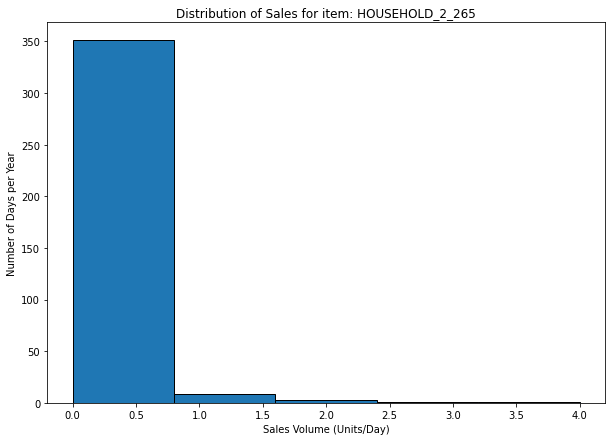

In [ ]:
# ABC SKU-LEVEL
df_dist = sales[sales['cat_id']=='HOUSEHOLD'].drop(['mean', 'std', 'CV'], axis = 1).copy()
df_dist = pd.DataFrame(df_dist.groupby(['item_id', 'dept_id', 'cat_id']).sum())
df_dist.reset_index(inplace = True)

# Item A
item_high = 'HOUSEHOLD_2_265'
df_dist = df_dist[df_dist['item_id']==item_high][COLS_DATE].T
df_dist.columns = ['Units']

# Simple histogram
df_dist['Units'].hist(figsize=(10,7), edgecolor='black', grid = False, bins = df_dist['Units'].nunique()) # , linewidth=1.2 , bins = 30
plt.xlabel('Sales Volume (Units/Day)')
plt.ylabel('Number of Days per Year')
plt.title('Distribution of Sales for item: {}'.format(item_high))
plt.show()